# Clasificación de canciones con perceptrón multinivel
### Javier Andres Tellez Ortiz - 201617861

### Se descarga el conjunto de datos y se descomprime

In [1]:
pip install wget

Note: you may need to restart the kernel to use updated packages.


In [2]:
import wget
from zipfile import ZipFile

##Se descarga el archivo del repositorio 
file = wget.download("http://millionsongdataset.com/sites/default/files/AdditionalFiles/msd_genre_dataset.zip")

##Se abre el archivo y se descomprime
zpFile = ZipFile(file)
zpFile.extractall()
zpFile.close()

100% [........................................................................] 12656044 / 12656044

### Se abre el conjunto de datos, se eliminan los datos con algún elemento faltante y se examina la estructura del mismo.

In [3]:
import pandas as pd
import numpy as np

dataset = pd.read_csv("msd_genre_dataset.txt", skiprows = range(9))

dataset.dropna()
dataset.head()

,%genre,track_id,artist_name,title,loudness,tempo,time_signature,key,mode,duration,...,var_timbre3,var_timbre4,var_timbre5,var_timbre6,var_timbre7,var_timbre8,var_timbre9,var_timbre10,var_timbre11,var_timbre12
0,classic pop and rock,TRFCOOU128F427AEC0,Blue Oyster Cult,Mes Dames Sarat,-8.697,155.007,1,9,1,246.33424,...,1255.514569,580.030472,598.485223,575.337671,322.068603,321.726029,232.700609,186.805303,181.938688,151.508011
1,classic pop and rock,TRNJTPB128F427AE9F,Blue Oyster Cult,Screams,-10.659,148.462,1,4,0,189.80526,...,2007.653070,1043.474073,585.694981,564.013736,510.177022,400.200186,365.119588,238.099708,197.933757,251.577525
2,classic pop and rock,TRLFJHA128F427AEEA,Blue Oyster Cult,Dance The Night Away,-13.494,112.909,1,10,0,158.19710,...,1204.856777,2736.520024,730.233239,665.203452,535.775111,439.335059,486.822970,265.333860,447.097987,251.880724
3,classic pop and rock,TRCQZAG128F427DB97,Blue Oyster Cult,Debbie Denise,-12.786,117.429,4,7,1,250.22649,...,809.755802,563.908070,492.803819,378.382799,372.875044,231.941957,246.313305,168.400152,85.282462,339.897173
4,classic pop and rock,TRNXMNM128F427DB8C,Blue Oyster Cult,(Don't Fear) The Reaper,-14.093,141.536,4,9,0,307.06893,...,1093.684935,343.556047,889.163314,218.111796,304.862864,178.352161,440.478867,142.669283,81.061326,208.355152


### Se obtienen los datos de las clases con los que se generará el modelo.  Previamente, se eliminaron las columnas 'track_id', 'artist_name' y 'title'

In [4]:
dataset = dataset.drop(columns = ["track_id", "artist_name", "title"])
features = dataset.columns.tolist()
dataset = dataset[(dataset["%genre"] == "jazz and blues") | (dataset["%genre"] == "soul and reggae")]

### Se obtiene la cantidad total de datos pertenecientes a cada clase

In [5]:
pd.DataFrame(dataset["%genre"].value_counts())

,%genre
jazz and blues,4334
soul and reggae,4016


### Se divide la información del archivo entre etiquetas y carácteristicas

In [6]:
y = dataset["%genre"].values
X = dataset.values[:,1:]

### Como se evidenció en entregas anteriores, es necesaria la estándarizacion de los datos. Además se tranforman las etiquetas de cada calse en números

In [7]:
from sklearn.preprocessing import StandardScaler, LabelEncoder

scaler = StandardScaler()
lblEncoder = LabelEncoder()

y = lblEncoder.fit(np.unique(y)).transform(y)
##Se estandarizan los datos provenientes del archivo
X = scaler.fit(X).transform(X)

### Se dividen los datos en datos de entrenamiento y datos de prueba, tomando el 20% del total para este último fin. Antes de realizar la división, los datos son barajados

In [8]:
from sklearn.model_selection import train_test_split

X, X_test, y, y_test = train_test_split(X, y, test_size = 0.2, random_state = 7861)

genres, cantidad = np.unique(y_test, return_counts = True)
total_test_data = sum(cantidad)
labels = lblEncoder.inverse_transform(genres)
print("Datos de prueba clase %s (%s): %d" % (genres[0],labels[0],cantidad[0]))
print("Datos de prueba clase %s (%s): %d" % (genres[1],labels[1],cantidad[1]))
print("Total datos prueba: %d" % total_test_data)

Datos de prueba clase 0 (jazz and blues): 879
Datos de prueba clase 1 (soul and reggae): 791
Total datos prueba: 1670


### Se toma el 10% de los datos de entrenamiento como datos de validación, esto con el objetivo de comparar cada uno de los modelos que serán entrenados

In [9]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size = 0.1, random_state = 7861)

genres, cantidad = np.unique(y_train, return_counts = True)
labels = lblEncoder.inverse_transform(genres)
print("Datos de entrenamiento clase %s (%s): %d" % (genres[0],labels[0],cantidad[0]))
print("Datos de entrenamiento clase %s (%s): %d" % (genres[1],labels[1],cantidad[1]))

genres, cantidad = np.unique(y_validation, return_counts = True)
labels = lblEncoder.inverse_transform(genres)
print("Datos de validacion clase %s (%s): %d" % (genres[0],labels[0],cantidad[0]))
print("Datos de validacion clase %s (%s): %d" % (genres[1],labels[1],cantidad[1]))

Datos de entrenamiento clase 0 (jazz and blues): 3123
Datos de entrenamiento clase 1 (soul and reggae): 2889
Datos de validacion clase 0 (jazz and blues): 332
Datos de validacion clase 1 (soul and reggae): 336


### Se realiza el entrenamiento de las redes neuronales cambiando la cantidad de neuronas en la capa escondida entre 2 y el total de dimensiones del problema

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def getMoldel(neurons, activation='relu', optimizer='adam'):
    model = Sequential()
    model.add(Dense(units=neurons, activation=activation, input_dim=X.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

In [11]:
best_models_neurons = []
best_models_loss = []

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

dimensions = X.shape[1] + 1
earlyStop = EarlyStopping(min_delta=1e-9)

for i in range(5):
    
    models_log_loss_valid = []
    
    for neurons in range(2,dimensions):
        
        model = getMoldel(neurons)    
        history_data = model.fit(X_train, y_train,
                                 validation_data=(X_validation,y_validation),
                                 epochs=2000,
                                 batch_size=32,
                                 verbose=1,
                                 callbacks=[earlyStop])

        models_log_loss_valid.append(history_data.history['val_loss'][-1])

    best_model_position = models_log_loss_valid.index(min(models_log_loss_valid))
    best_model_neurons = best_model_position + 2
    print("El modelo con mejor desempeño tiene %d neuronas en la capa oculta" % best_model_neurons)

    best_models_loss.append(min(models_log_loss_valid))
    best_models_neurons.append(best_model_neurons)

Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 3s 424us/sample - loss: 0.6614 - val_loss: 0.5842
Epoch 2/2000
6012/6012 [==============================] - 0s 73us/sample - loss: 0.5487 - val_loss: 0.5253
Epoch 3/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.5032 - val_loss: 0.4939
Epoch 4/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.4755 - val_loss: 0.4723
Epoch 5/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.4557 - val_loss: 0.4560
Epoch 6/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.4405 - val_loss: 0.4437
Epoch 7/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.4294 - val_loss: 0.4334
Epoch 8/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.4199 - val_loss: 0.4268
Epoch 9/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.4120 - val_lo

6012/6012 [==============================] - 0s 65us/sample - loss: 0.4387 - val_loss: 0.4314
Epoch 9/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.4283 - val_loss: 0.4218
Epoch 10/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.4195 - val_loss: 0.4131
Epoch 11/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.4114 - val_loss: 0.4050
Epoch 12/2000
6012/6012 [==============================] - 0s 68us/sample - loss: 0.4049 - val_loss: 0.3990
Epoch 13/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3989 - val_loss: 0.3917
Epoch 14/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3934 - val_loss: 0.3862
Epoch 15/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3886 - val_loss: 0.3840
Epoch 16/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3838 - val_loss: 0.3784
Epoch 17/2000
6012/6012 [==================

6012/6012 [==============================] - 0s 55us/sample - loss: 0.3391 - val_loss: 0.3500
Epoch 10/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3351 - val_loss: 0.3462
Epoch 11/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3311 - val_loss: 0.3433
Epoch 12/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3276 - val_loss: 0.3402
Epoch 13/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3245 - val_loss: 0.3374
Epoch 14/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3216 - val_loss: 0.3372
Epoch 15/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3191 - val_loss: 0.3355
Epoch 16/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3170 - val_loss: 0.3340
Epoch 17/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3148 - val_loss: 0.3334
Epoch 18/2000
6012/6012 [=================

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3314 - val_loss: 0.3356
Epoch 9/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3266 - val_loss: 0.3334
Epoch 10/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3221 - val_loss: 0.3329
Epoch 11/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3181 - val_loss: 0.3328
Epoch 12/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3140 - val_loss: 0.3305
Epoch 13/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3099 - val_loss: 0.3298
Epoch 14/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3065 - val_loss: 0.3291
Epoch 15/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3037 - val_loss: 0.3260
Epoch 16/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3004 - val_loss: 0.3253
Epoch 17/2000
6012/6012 [==================

Epoch 7/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3255 - val_loss: 0.3422
Epoch 8/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3206 - val_loss: 0.3408
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3160 - val_loss: 0.3408
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 213us/sample - loss: 0.5430 - val_loss: 0.4024
Epoch 2/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3969 - val_loss: 0.3672
Epoch 3/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3694 - val_loss: 0.3586
Epoch 4/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3556 - val_loss: 0.3502
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3458 - val_loss: 0.3461
Epoch 6/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3382 - val_lo

6012/6012 [==============================] - 1s 161us/sample - loss: 0.5076 - val_loss: 0.3944
Epoch 2/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3823 - val_loss: 0.3666
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3603 - val_loss: 0.3502
Epoch 4/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3479 - val_loss: 0.3423
Epoch 5/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3389 - val_loss: 0.3381
Epoch 6/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3328 - val_loss: 0.3334
Epoch 7/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3261 - val_loss: 0.3254
Epoch 8/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3204 - val_loss: 0.3257
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 159us/sample - loss: 0.4793 - val_loss: 0.3639
E

Epoch 32/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3419 - val_loss: 0.3456
Epoch 33/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3412 - val_loss: 0.3457
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 159us/sample - loss: 0.5311 - val_loss: 0.4605
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4337 - val_loss: 0.4108
Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3983 - val_loss: 0.3933
Epoch 4/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3823 - val_loss: 0.3853
Epoch 5/2000
6012/6012 [==============================] - 0s 52us/sample - loss: 0.3735 - val_loss: 0.3810
Epoch 6/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3675 - val_loss: 0.3788
Epoch 7/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3623 - val_

6012/6012 [==============================] - 0s 58us/sample - loss: 0.3137 - val_loss: 0.3194
Epoch 29/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3125 - val_loss: 0.3198
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 160us/sample - loss: 0.6070 - val_loss: 0.4556
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4242 - val_loss: 0.3862
Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3811 - val_loss: 0.3706
Epoch 4/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3650 - val_loss: 0.3633
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3552 - val_loss: 0.3592
Epoch 6/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3494 - val_loss: 0.3551
Epoch 7/2000
6012/6012 [==============================] - 0s 52us/sample - loss: 0.3442 - val_loss: 0.3516
E

6012/6012 [==============================] - 1s 211us/sample - loss: 0.5021 - val_loss: 0.4027
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3907 - val_loss: 0.3694
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3693 - val_loss: 0.3584
Epoch 4/2000
6012/6012 [==============================] - 0s 58us/sample - loss: 0.3576 - val_loss: 0.3522
Epoch 5/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3494 - val_loss: 0.3452
Epoch 6/2000
6012/6012 [==============================] - 0s 70us/sample - loss: 0.3427 - val_loss: 0.3433
Epoch 7/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3373 - val_loss: 0.3382
Epoch 8/2000
6012/6012 [==============================] - 0s 70us/sample - loss: 0.3324 - val_loss: 0.3358
Epoch 9/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3282 - val_loss: 0.3332
Epoch 10/2000
6012/6012 [========================

Epoch 7/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3288 - val_loss: 0.3356
Epoch 8/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3248 - val_loss: 0.3313
Epoch 9/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3202 - val_loss: 0.3325
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 185us/sample - loss: 0.4953 - val_loss: 0.3817
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3766 - val_loss: 0.3491
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3522 - val_loss: 0.3388
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3416 - val_loss: 0.3333
Epoch 5/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3334 - val_loss: 0.3289
Epoch 6/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3274 - val_lo

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3116 - val_loss: 0.3184
Epoch 11/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3080 - val_loss: 0.3136
Epoch 12/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3045 - val_loss: 0.3175
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 159us/sample - loss: 0.5183 - val_loss: 0.3822
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3838 - val_loss: 0.3533
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3597 - val_loss: 0.3433
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3464 - val_loss: 0.3359
Epoch 5/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3377 - val_loss: 0.3325
Epoch 6/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3304 - val_loss: 0.3303


6012/6012 [==============================] - 0s 57us/sample - loss: 0.3806 - val_loss: 0.3735
Epoch 19/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3778 - val_loss: 0.3700
Epoch 20/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3754 - val_loss: 0.3678
Epoch 21/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3730 - val_loss: 0.3654
Epoch 22/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3706 - val_loss: 0.3631
Epoch 23/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3694 - val_loss: 0.3619
Epoch 24/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3674 - val_loss: 0.3607
Epoch 25/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3659 - val_loss: 0.3580
Epoch 26/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3646 - val_loss: 0.3579
Epoch 27/2000
6012/6012 [=================

Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 159us/sample - loss: 0.6972 - val_loss: 0.5194
Epoch 2/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.4649 - val_loss: 0.4242
Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4068 - val_loss: 0.3922
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3833 - val_loss: 0.3771
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3710 - val_loss: 0.3681
Epoch 6/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3625 - val_loss: 0.3596
Epoch 7/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3563 - val_loss: 0.3532
Epoch 8/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3509 - val_loss: 0.3487
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3463 - val_lo

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3582 - val_loss: 0.3563
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3502 - val_loss: 0.3506
Epoch 6/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3443 - val_loss: 0.3470
Epoch 7/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3393 - val_loss: 0.3443
Epoch 8/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3352 - val_loss: 0.3431
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3313 - val_loss: 0.3395
Epoch 10/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3281 - val_loss: 0.3387
Epoch 11/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3249 - val_loss: 0.3362
Epoch 12/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3221 - val_loss: 0.3354
Epoch 13/2000
6012/6012 [======================

6012/6012 [==============================] - 0s 55us/sample - loss: 0.3194 - val_loss: 0.3275
Epoch 12/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3156 - val_loss: 0.3303
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 161us/sample - loss: 0.5924 - val_loss: 0.4239
Epoch 2/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.4072 - val_loss: 0.3761
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3715 - val_loss: 0.3624
Epoch 4/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3573 - val_loss: 0.3541
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3483 - val_loss: 0.3484
Epoch 6/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3420 - val_loss: 0.3438
Epoch 7/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3359 - val_loss: 0.3393
E

Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3360 - val_loss: 0.3403
Epoch 6/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3293 - val_loss: 0.3352
Epoch 7/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3251 - val_loss: 0.3341
Epoch 8/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3196 - val_loss: 0.3365
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 161us/sample - loss: 0.5178 - val_loss: 0.4040
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3873 - val_loss: 0.3754
Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3589 - val_loss: 0.3598
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3448 - val_loss: 0.3529
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3350 - val_lo

Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 159us/sample - loss: 0.6854 - val_loss: 0.6022
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.5829 - val_loss: 0.5449
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.5367 - val_loss: 0.5087
Epoch 4/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.5046 - val_loss: 0.4831
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4804 - val_loss: 0.4631
Epoch 6/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4613 - val_loss: 0.4469
Epoch 7/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4463 - val_loss: 0.4329
Epoch 8/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4343 - val_loss: 0.4217
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4243 - val_lo

Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3835 - val_loss: 0.3748
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3681 - val_loss: 0.3630
Epoch 6/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3583 - val_loss: 0.3544
Epoch 7/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3515 - val_loss: 0.3480
Epoch 8/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3458 - val_loss: 0.3439
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3410 - val_loss: 0.3407
Epoch 10/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3369 - val_loss: 0.3371
Epoch 11/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3328 - val_loss: 0.3359
Epoch 12/2000
6012/6012 [==============================] - 0s 52us/sample - loss: 0.3291 - val_loss: 0.3338
Epoch 13/2000
6012/6012 [=========

6012/6012 [==============================] - 0s 57us/sample - loss: 0.4128 - val_loss: 0.3661
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3723 - val_loss: 0.3491
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3558 - val_loss: 0.3428
Epoch 5/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3462 - val_loss: 0.3389
Epoch 6/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3398 - val_loss: 0.3368
Epoch 7/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3348 - val_loss: 0.3341
Epoch 8/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3303 - val_loss: 0.3315
Epoch 9/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3263 - val_loss: 0.3308
Epoch 10/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3230 - val_loss: 0.3270
Epoch 11/2000
6012/6012 [========================

Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3607 - val_loss: 0.3656
Epoch 4/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3490 - val_loss: 0.3566
Epoch 5/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3423 - val_loss: 0.3511
Epoch 6/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3362 - val_loss: 0.3471
Epoch 7/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3308 - val_loss: 0.3430
Epoch 8/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3259 - val_loss: 0.3383
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3217 - val_loss: 0.3406
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 166us/sample - loss: 0.5556 - val_loss: 0.4162
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3966 - val_lo

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3154 - val_loss: 0.3252
Epoch 11/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3114 - val_loss: 0.3240
Epoch 12/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3074 - val_loss: 0.3197
Epoch 13/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3040 - val_loss: 0.3188
Epoch 14/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3010 - val_loss: 0.3176
Epoch 15/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.2978 - val_loss: 0.3136
Epoch 16/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.2949 - val_loss: 0.3139
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 161us/sample - loss: 0.4734 - val_loss: 0.3893
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3747 - val_loss: 0.3

6012/6012 [==============================] - 1s 161us/sample - loss: 0.4969 - val_loss: 0.3796
Epoch 2/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3773 - val_loss: 0.3588
Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3566 - val_loss: 0.3479
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3447 - val_loss: 0.3444
Epoch 5/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3355 - val_loss: 0.3368
Epoch 6/2000
6012/6012 [==============================] - 0s 63us/sample - loss: 0.3284 - val_loss: 0.3366
Epoch 7/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3228 - val_loss: 0.3332
Epoch 8/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3168 - val_loss: 0.3320
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3107 - val_loss: 0.3299
Epoch 10/2000
6012/6012 [========================

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3440 - val_loss: 0.3479
Epoch 10/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3409 - val_loss: 0.3462
Epoch 11/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3383 - val_loss: 0.3429
Epoch 12/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3353 - val_loss: 0.3404
Epoch 13/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3327 - val_loss: 0.3398
Epoch 14/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3299 - val_loss: 0.3404
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 161us/sample - loss: 0.6091 - val_loss: 0.4791
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4405 - val_loss: 0.3951
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3935 - val_loss: 0.37

6012/6012 [==============================] - 1s 174us/sample - loss: 0.5114 - val_loss: 0.4034
Epoch 2/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3999 - val_loss: 0.3710
Epoch 3/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3752 - val_loss: 0.3617
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3631 - val_loss: 0.3570
Epoch 5/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3548 - val_loss: 0.3509
Epoch 6/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3473 - val_loss: 0.3448
Epoch 7/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3412 - val_loss: 0.3425
Epoch 8/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3362 - val_loss: 0.3384
Epoch 9/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3315 - val_loss: 0.3345
Epoch 10/2000
6012/6012 [========================

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3246 - val_loss: 0.3458
Epoch 12/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3208 - val_loss: 0.3420
Epoch 13/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3178 - val_loss: 0.3402
Epoch 14/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3149 - val_loss: 0.3419
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 164us/sample - loss: 0.5622 - val_loss: 0.4233
Epoch 2/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.4087 - val_loss: 0.3854
Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3796 - val_loss: 0.3706
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3639 - val_loss: 0.3605
Epoch 5/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3531 - val_loss: 0.3530

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3327 - val_loss: 0.3316
Epoch 7/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3266 - val_loss: 0.3272
Epoch 8/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3211 - val_loss: 0.3244
Epoch 9/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3160 - val_loss: 0.3213
Epoch 10/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3121 - val_loss: 0.3179
Epoch 11/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3078 - val_loss: 0.3175
Epoch 12/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3042 - val_loss: 0.3195
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 164us/sample - loss: 0.4708 - val_loss: 0.3888
Epoch 2/2000
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3754 - val_loss: 0.3683

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3136 - val_loss: 0.3294
Epoch 10/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3089 - val_loss: 0.3261
Epoch 11/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3049 - val_loss: 0.3203
Epoch 12/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3007 - val_loss: 0.3182
Epoch 13/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.2971 - val_loss: 0.3216
El modelo con mejor desempeño tiene 26 neuronas en la capa oculta


### El proceso de entrenamiento se repitió 5 veces y se obtuvieron los resultados mostrados a continuacón. Para cada repetición se eligió el modelo con mejor rendimiento y este es el que se muestra en la gráfica junto con su respectiva pérdida

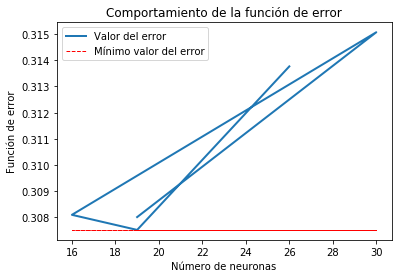

In [13]:
import pylab as pl

def plot_model_info(x,y,x_label):
    
    pl.plot(x, y,
            linewidth=2,
            label='Valor del error')

    pl.plot(x,[min(y)]*len(x),
            linestyle = '--',
            linewidth = 1,
            color = 'red',
            label = 'Mínimo valor del error')

    pl.xlabel(x_label)
    pl.ylabel('Función de error')
    pl.title('Comportamiento de la función de error')
    pl.legend()
    pl.show()
    
plot_model_info(best_models_neurons,best_models_loss,'Número de neuronas')

### A partir de los datos de la gráfica es posible afirmar que:

In [14]:
hidden_layer_neurons = best_models_neurons[best_models_loss.index(min(best_models_loss))]
print('La arquitectura con mejor desempeño tiene %d neuronas en la capa escondida' % (hidden_layer_neurons))

La arquitectura con mejor desempeño tiene 19 neuronas en la capa escondida


### Una vez obtenida la arquitectura con mejor rendimiento, se busca la función de activación que permite obtener mejores rendimientos. Este procedimiento también es repetido 5 veces.

In [15]:
activations = ['relu','linear', 'sigmoid', 'tanh', 'selu', 'softplus']
neurons = hidden_layer_neurons

best_models_activation = []
best_models_activations_loss = []

for i in range(5): 
    models_activation_log_loss = []
    
    for activation in activations:
        model = getMoldel(neurons, activation=activation)

        history = model.fit(X_train, y_train,
                            validation_data=(X_validation,y_validation),
                            epochs=2000,
                            batch_size=32,
                            verbose=1,
                            callbacks=[earlyStop])

        models_activation_log_loss.append(history.history['val_loss'][-1])

    best_activation_model_position = (models_activation_log_loss.index(min(models_activation_log_loss)))
    best_activation = activations[best_activation_model_position]
    print("El modelo con mejor rendimiento usó %s como función de activación" % best_activation)
    
    best_models_activation.append(best_activation)
    best_models_activations_loss.append(min(models_activation_log_loss))

Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 169us/sample - loss: 0.5719 - val_loss: 0.4356
Epoch 2/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3961 - val_loss: 0.3828
Epoch 3/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3685 - val_loss: 0.3674
Epoch 4/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3568 - val_loss: 0.3628
Epoch 5/2000
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3484 - val_loss: 0.3541
Epoch 6/2000
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3420 - val_loss: 0.3493
Epoch 7/2000
6012/6012 [==============================] - 0s 70us/sample - loss: 0.3362 - val_loss: 0.3471
Epoch 8/2000
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3319 - val_loss: 0.3421
Epoch 9/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3267 - val_lo

6012/6012 [==============================] - 0s 55us/sample - loss: 0.3839 - val_loss: 0.3744
Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3704 - val_loss: 0.3649
Epoch 4/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3637 - val_loss: 0.3608
Epoch 5/2000
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3596 - val_loss: 0.3602
Epoch 6/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3553 - val_loss: 0.3570
Epoch 7/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3524 - val_loss: 0.3548
Epoch 8/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3486 - val_loss: 0.3516
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3462 - val_loss: 0.3525
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 177us/sample - loss: 0.4497 - val_loss: 0.3783
Ep

6012/6012 [==============================] - 0s 55us/sample - loss: 0.3308 - val_loss: 0.3407
Epoch 9/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3263 - val_loss: 0.3394
Epoch 10/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3208 - val_loss: 0.3383
Epoch 11/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3175 - val_loss: 0.3326
Epoch 12/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3134 - val_loss: 0.3308
Epoch 13/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3098 - val_loss: 0.3289
Epoch 14/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3064 - val_loss: 0.3300
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 159us/sample - loss: 0.4620 - val_loss: 0.3910
Epoch 2/2000
6012/6012 [==============================] - 0s 58us/sample - loss: 0.3823 - val_loss: 0.37

6012/6012 [==============================] - 0s 55us/sample - loss: 0.3658 - val_loss: 0.3627
Epoch 8/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3637 - val_loss: 0.3593
Epoch 9/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3621 - val_loss: 0.3592
Epoch 10/2000
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3607 - val_loss: 0.3595
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 [==============================] - 1s 169us/sample - loss: 0.4876 - val_loss: 0.3792
Epoch 2/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3790 - val_loss: 0.3639
Epoch 3/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3668 - val_loss: 0.3602
Epoch 4/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3615 - val_loss: 0.3563
Epoch 5/2000
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3573 - val_loss: 0.3542
E

### Se grafica la mejor función de activación para cada iteración junto con su respectiva pérdida. Para todos los casos ReLU fue la función con mejor rendimiento.

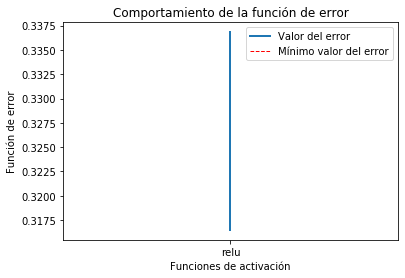

Durante las pruebas ejecutadas, el modelo con mejor desempeño usó relu como funcion de activacion


In [16]:
plot_model_info(best_models_activation,best_models_activations_loss,'Funciones de activación')
best_activation = best_models_activation[best_models_activations_loss.index(min(best_models_activations_loss))]
print('Durante las pruebas ejecutadas, el modelo con mejor desempeño usó %s como funcion de activacion' % best_activation)

### De acuerdo con los resultados anteriores, es posible escoger la arquitectura y la función de activación del modelo. A continuación, se procede a probar diferentes algortimos de descenso de gradiente

In [17]:
algorithms = ['Adagrad', 'Adam', 'Adamax', 'RMSprop']

models_algorithms_log_loss = []

for algorithm in algorithms:
    model = getMoldel(neurons, activation=best_activation, optimizer=algorithm)

    history = model.fit(X_train, y_train,
                        validation_data=(X_validation,y_validation),
                        epochs=200,
                        batch_size=32,
                        verbose=1,
                        callbacks=[earlyStop])

    models_algorithms_log_loss.append(history.history['val_loss'][-1])
    
best_algorithm_model_position = (models_algorithms_log_loss.index(min(models_algorithms_log_loss)))
best_algorithm = algorithms[best_algorithm_model_position]

Train on 6012 samples, validate on 668 samples
Epoch 1/200
6012/6012 [==============================] - 1s 182us/sample - loss: 0.6794 - val_loss: 0.6181
Epoch 2/200
6012/6012 [==============================] - 0s 57us/sample - loss: 0.6222 - val_loss: 0.5788
Epoch 3/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.5927 - val_loss: 0.5534
Epoch 4/200
6012/6012 [==============================] - 0s 57us/sample - loss: 0.5721 - val_loss: 0.5346
Epoch 5/200
6012/6012 [==============================] - 0s 62us/sample - loss: 0.5564 - val_loss: 0.5198
Epoch 6/200
6012/6012 [==============================] - 0s 65us/sample - loss: 0.5437 - val_loss: 0.5077
Epoch 7/200
6012/6012 [==============================] - 0s 65us/sample - loss: 0.5330 - val_loss: 0.4975
Epoch 8/200
6012/6012 [==============================] - 0s 62us/sample - loss: 0.5239 - val_loss: 0.4887
Epoch 9/200
6012/6012 [==============================] - 0s 60us/sample - loss: 0.5160 - val_loss: 0.481

6012/6012 [==============================] - 0s 57us/sample - loss: 0.4014 - val_loss: 0.3744
Epoch 78/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.4010 - val_loss: 0.3740
Epoch 79/200
6012/6012 [==============================] - 0s 57us/sample - loss: 0.4005 - val_loss: 0.3737
Epoch 80/200
6012/6012 [==============================] - 0s 52us/sample - loss: 0.4000 - val_loss: 0.3733
Epoch 81/200
6012/6012 [==============================] - 0s 52us/sample - loss: 0.3996 - val_loss: 0.3730
Epoch 82/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3992 - val_loss: 0.3726
Epoch 83/200
6012/6012 [==============================] - 0s 52us/sample - loss: 0.3987 - val_loss: 0.3723
Epoch 84/200
6012/6012 [==============================] - 0s 52us/sample - loss: 0.3983 - val_loss: 0.3720
Epoch 85/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3979 - val_loss: 0.3717
Epoch 86/200
6012/6012 [==========================

6012/6012 [==============================] - 0s 55us/sample - loss: 0.3800 - val_loss: 0.3585
Epoch 154/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3798 - val_loss: 0.3584
Epoch 155/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3796 - val_loss: 0.3583
Epoch 156/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3795 - val_loss: 0.3582
Epoch 157/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3793 - val_loss: 0.3581
Epoch 158/200
6012/6012 [==============================] - 0s 52us/sample - loss: 0.3791 - val_loss: 0.3580
Epoch 159/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3790 - val_loss: 0.3578
Epoch 160/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3788 - val_loss: 0.3577
Epoch 161/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3786 - val_loss: 0.3576
Epoch 162/200
6012/6012 [=================

6012/6012 [==============================] - 0s 57us/sample - loss: 0.3463 - val_loss: 0.3547
Epoch 13/200
6012/6012 [==============================] - 0s 52us/sample - loss: 0.3433 - val_loss: 0.3516
Epoch 14/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3407 - val_loss: 0.3497
Epoch 15/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3384 - val_loss: 0.3474
Epoch 16/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3363 - val_loss: 0.3457
Epoch 17/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3343 - val_loss: 0.3433
Epoch 18/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3323 - val_loss: 0.3423
Epoch 19/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3305 - val_loss: 0.3408
Epoch 20/200
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3291 - val_loss: 0.3396
Epoch 21/200
6012/6012 [==========================

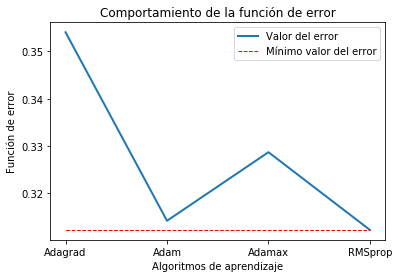

El modelo con mejor rendimiento usó RMSprop como algoritmo de entrenamiento


In [18]:
plot_model_info(algorithms,models_algorithms_log_loss,'Algoritmos de aprendizaje')
print("El modelo con mejor rendimiento usó %s como algoritmo de entrenamiento" % best_algorithm)

### Con los parámetros obtenidos anteriormente, se procede a variar la tasa de aprendizaje con el fin de escoger la que mejor se adapta al problema estudiado

In [80]:
from tensorflow.keras.optimizers import get

learning_rates = [0.00001,0.00003,
                 0.0001, 0.0003,
                 0.001, 0.003,
                 0.01, 0.03,
                 0.1, 0.3,
                 1, 3]

algorithm = best_algorithm
models_lr_log_loss = []

for learning_rate in learning_rates:
    
    optimizer = get(algorithm).from_config({'learning_rate':learning_rate})
    model = getMoldel(neurons, activation=best_activation, optimizer=optimizer)

    history = model.fit(X_train, y_train,
                        validation_data=(X_validation,y_validation),
                        epochs=300,
                        batch_size=32,
                        verbose=1,
                        callbacks=[earlyStop])

    models_lr_log_loss.append(history.history['val_loss'][-1])
    
best_lr_model_position = (models_lr_log_loss.index(min(models_lr_log_loss)))
best_lr = learning_rates[best_lr_model_position]

Train on 6012 samples, validate on 668 samples
Epoch 1/300
6012/6012 [==============================] - 1s 226us/sample - loss: 0.6849 - val_loss: 0.6676
Epoch 2/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.6773 - val_loss: 0.6596
Epoch 3/300
6012/6012 [==============================] - 0s 73us/sample - loss: 0.6699 - val_loss: 0.6519
Epoch 4/300
6012/6012 [==============================] - 0s 78us/sample - loss: 0.6626 - val_loss: 0.6443
Epoch 5/300
6012/6012 [==============================] - 0s 75us/sample - loss: 0.6556 - val_loss: 0.6370
Epoch 6/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.6488 - val_loss: 0.6299
Epoch 7/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.6421 - val_loss: 0.6230
Epoch 8/300
6012/6012 [==============================] - 0s 70us/sample - loss: 0.6357 - val_loss: 0.6164
Epoch 9/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.6294 - val_loss: 0.609

6012/6012 [==============================] - 0s 60us/sample - loss: 0.4302 - val_loss: 0.4131
Epoch 78/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.4290 - val_loss: 0.4121
Epoch 79/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.4278 - val_loss: 0.4110
Epoch 80/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.4267 - val_loss: 0.4100
Epoch 81/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.4255 - val_loss: 0.4090
Epoch 82/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.4244 - val_loss: 0.4081
Epoch 83/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.4233 - val_loss: 0.4072
Epoch 84/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.4222 - val_loss: 0.4063
Epoch 85/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.4212 - val_loss: 0.4054
Epoch 86/300
6012/6012 [==========================

Epoch 153/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3813 - val_loss: 0.3750
Epoch 154/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3810 - val_loss: 0.3747
Epoch 155/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3807 - val_loss: 0.3745
Epoch 156/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3803 - val_loss: 0.3743
Epoch 157/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3800 - val_loss: 0.3741
Epoch 158/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3797 - val_loss: 0.3739
Epoch 159/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3794 - val_loss: 0.3737
Epoch 160/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3791 - val_loss: 0.3735
Epoch 161/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3788 - val_loss: 0.3733
Epoch 162/300
6012/6012 [===

Epoch 229/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3638 - val_loss: 0.3640
Epoch 230/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3636 - val_loss: 0.3639
Epoch 231/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3635 - val_loss: 0.3638
Epoch 232/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3633 - val_loss: 0.3637
Epoch 233/300
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3632 - val_loss: 0.3636
Epoch 234/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3630 - val_loss: 0.3635
Epoch 235/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3628 - val_loss: 0.3634
Epoch 236/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3627 - val_loss: 0.3633
Epoch 237/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3625 - val_loss: 0.3632
Epoch 238/300
6012/6012 [===

6012/6012 [==============================] - 0s 62us/sample - loss: 0.5958 - val_loss: 0.5717
Epoch 5/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.5770 - val_loss: 0.5532
Epoch 6/300
6012/6012 [==============================] - 0s 55us/sample - loss: 0.5602 - val_loss: 0.5366
Epoch 7/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.5450 - val_loss: 0.5215
Epoch 8/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.5313 - val_loss: 0.5081
Epoch 9/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.5189 - val_loss: 0.4962
Epoch 10/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.5077 - val_loss: 0.4853
Epoch 11/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.4975 - val_loss: 0.4756
Epoch 12/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.4883 - val_loss: 0.4668
Epoch 13/300
6012/6012 [==============================]

6012/6012 [==============================] - 0s 62us/sample - loss: 0.3608 - val_loss: 0.3575
Epoch 81/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3604 - val_loss: 0.3571
Epoch 82/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3599 - val_loss: 0.3567
Epoch 83/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3595 - val_loss: 0.3564
Epoch 84/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3591 - val_loss: 0.3560
Epoch 85/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3587 - val_loss: 0.3556
Epoch 86/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3583 - val_loss: 0.3553
Epoch 87/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3579 - val_loss: 0.3550
Epoch 88/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3575 - val_loss: 0.3547
Epoch 89/300
6012/6012 [==========================

6012/6012 [==============================] - 0s 70us/sample - loss: 0.3393 - val_loss: 0.3408
Epoch 157/300
6012/6012 [==============================] - 0s 70us/sample - loss: 0.3391 - val_loss: 0.3406
Epoch 158/300
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3389 - val_loss: 0.3405
Epoch 159/300
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3387 - val_loss: 0.3404
Epoch 160/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3385 - val_loss: 0.3403
Epoch 161/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3383 - val_loss: 0.3402
Epoch 162/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3381 - val_loss: 0.3401
Epoch 163/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3379 - val_loss: 0.3400
Epoch 164/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3377 - val_loss: 0.3399
Epoch 165/300
6012/6012 [=================

Epoch 232/300
6012/6012 [==============================] - 0s 73us/sample - loss: 0.3270 - val_loss: 0.3347
Epoch 233/300
6012/6012 [==============================] - 0s 55us/sample - loss: 0.3269 - val_loss: 0.3346
Epoch 234/300
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3267 - val_loss: 0.3346
Epoch 235/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3266 - val_loss: 0.3346
Epoch 236/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3265 - val_loss: 0.3345
Epoch 237/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3264 - val_loss: 0.3345
Epoch 238/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3262 - val_loss: 0.3345
Epoch 239/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3261 - val_loss: 0.3345
Epoch 240/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3260 - val_loss: 0.3344
Epoch 241/300
6012/6012 [===

6012/6012 [==============================] - 0s 60us/sample - loss: 0.3602 - val_loss: 0.3533
Epoch 23/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3584 - val_loss: 0.3521
Epoch 24/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3568 - val_loss: 0.3510
Epoch 25/300
6012/6012 [==============================] - 0s 57us/sample - loss: 0.3552 - val_loss: 0.3498
Epoch 26/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3537 - val_loss: 0.3487
Epoch 27/300
6012/6012 [==============================] - 0s 70us/sample - loss: 0.3523 - val_loss: 0.3477
Epoch 28/300
6012/6012 [==============================] - 0s 73us/sample - loss: 0.3511 - val_loss: 0.3467
Epoch 29/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3498 - val_loss: 0.3457
Epoch 30/300
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3487 - val_loss: 0.3448
Epoch 31/300
6012/6012 [==========================

6012/6012 [==============================] - 0s 68us/sample - loss: 0.3438 - val_loss: 0.3431
Epoch 16/300
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3412 - val_loss: 0.3398
Epoch 17/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3386 - val_loss: 0.3372
Epoch 18/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3364 - val_loss: 0.3349
Epoch 19/300
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3343 - val_loss: 0.3332
Epoch 20/300
6012/6012 [==============================] - 0s 65us/sample - loss: 0.3325 - val_loss: 0.3310
Epoch 21/300
6012/6012 [==============================] - 0s 60us/sample - loss: 0.3305 - val_loss: 0.3290
Epoch 22/300
6012/6012 [==============================] - 0s 62us/sample - loss: 0.3287 - val_loss: 0.3268
Epoch 23/300
6012/6012 [==============================] - 0s 68us/sample - loss: 0.3270 - val_loss: 0.3255
Epoch 24/300
6012/6012 [==========================

### Se grafica cada una de las tasas de aprendizaje usadas y se escoge la que obtuvo menores pérdidas con un número máximo de iteraciones igual a 300. El entrenamiento se suspendia si se observaba un aumento en la función de error o un mejoramiento menor a $10^{-9}$

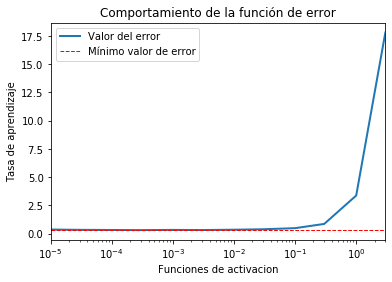

El modelo con mejor rendimiento usó 0.000300 como tasa de aprendizaje


In [81]:
pl.semilogx(learning_rates, 
        models_lr_log_loss,
        linewidth=2,
        label='Valor del error')

pl.semilogx(learning_rates,
        [models_lr_log_loss[best_lr_model_position]] * len(learning_rates),
        linestyle = '--',
        linewidth = 1,
        color = 'red',
        label = 'Mínimo valor de error')

pl.xlabel('Funciones de activacion')
pl.ylabel('Tasa de aprendizaje')
pl.title('Comportamiento de la función de error')
pl.legend()
pl.xlim(min(learning_rates), max(learning_rates))
pl.show()
print("El modelo con mejor rendimiento usó %f como tasa de aprendizaje" % best_lr)

### Con la información obtenida, se entrena el modelo con el cojunto de entrenamiento completo

In [21]:
from tensorflow.keras.metrics import binary_accuracy
from tensorflow import squeeze

optimizer = get(algorithm).from_config({'learning_rate':best_lr})
model = getMoldel(neurons, activation=best_activation, optimizer=optimizer)
model.fit(X, y,
          epochs=500,
          batch_size=32,
          verbose=2)

Train on 6680 samples
Epoch 1/500
6680/6680 - 1s - loss: 0.4998
Epoch 2/500
6680/6680 - 0s - loss: 0.3876
Epoch 3/500
6680/6680 - 0s - loss: 0.3649
Epoch 4/500
6680/6680 - 0s - loss: 0.3528
Epoch 5/500
6680/6680 - 0s - loss: 0.3445
Epoch 6/500
6680/6680 - 0s - loss: 0.3388
Epoch 7/500
6680/6680 - 0s - loss: 0.3337
Epoch 8/500
6680/6680 - 0s - loss: 0.3296
Epoch 9/500
6680/6680 - 0s - loss: 0.3255
Epoch 10/500
6680/6680 - 0s - loss: 0.3220
Epoch 11/500
6680/6680 - 0s - loss: 0.3189
Epoch 12/500
6680/6680 - 0s - loss: 0.3161
Epoch 13/500
6680/6680 - 0s - loss: 0.3129
Epoch 14/500
6680/6680 - 0s - loss: 0.3101
Epoch 15/500
6680/6680 - 0s - loss: 0.3076
Epoch 16/500
6680/6680 - 0s - loss: 0.3052
Epoch 17/500
6680/6680 - 0s - loss: 0.3030
Epoch 18/500
6680/6680 - 0s - loss: 0.3005
Epoch 19/500
6680/6680 - 0s - loss: 0.2984
Epoch 20/500
6680/6680 - 0s - loss: 0.2965
Epoch 21/500
6680/6680 - 0s - loss: 0.2948
Epoch 22/500
6680/6680 - 0s - loss: 0.2925
Epoch 23/500
6680/6680 - 0s - loss: 0.291

6680/6680 - 0s - loss: 0.2265
Epoch 190/500
6680/6680 - 0s - loss: 0.2261
Epoch 191/500
6680/6680 - 0s - loss: 0.2264
Epoch 192/500
6680/6680 - 0s - loss: 0.2258
Epoch 193/500
6680/6680 - 0s - loss: 0.2264
Epoch 194/500
6680/6680 - 0s - loss: 0.2259
Epoch 195/500
6680/6680 - 0s - loss: 0.2254
Epoch 196/500
6680/6680 - 0s - loss: 0.2264
Epoch 197/500
6680/6680 - 0s - loss: 0.2258
Epoch 198/500
6680/6680 - 0s - loss: 0.2259
Epoch 199/500
6680/6680 - 0s - loss: 0.2248
Epoch 200/500
6680/6680 - 0s - loss: 0.2256
Epoch 201/500
6680/6680 - 0s - loss: 0.2249
Epoch 202/500
6680/6680 - 0s - loss: 0.2254
Epoch 203/500
6680/6680 - 0s - loss: 0.2253
Epoch 204/500
6680/6680 - 0s - loss: 0.2248
Epoch 205/500
6680/6680 - 0s - loss: 0.2248
Epoch 206/500
6680/6680 - 0s - loss: 0.2240
Epoch 207/500
6680/6680 - 0s - loss: 0.2247
Epoch 208/500
6680/6680 - 0s - loss: 0.2247
Epoch 209/500
6680/6680 - 0s - loss: 0.2242
Epoch 210/500
6680/6680 - 0s - loss: 0.2239
Epoch 211/500
6680/6680 - 0s - loss: 0.2235
Ep

Epoch 376/500
6680/6680 - 0s - loss: 0.2122
Epoch 377/500
6680/6680 - 0s - loss: 0.2117
Epoch 378/500
6680/6680 - 0s - loss: 0.2126
Epoch 379/500
6680/6680 - 0s - loss: 0.2126
Epoch 380/500
6680/6680 - 0s - loss: 0.2130
Epoch 381/500
6680/6680 - 0s - loss: 0.2127
Epoch 382/500
6680/6680 - 0s - loss: 0.2122
Epoch 383/500
6680/6680 - 0s - loss: 0.2120
Epoch 384/500
6680/6680 - 0s - loss: 0.2122
Epoch 385/500
6680/6680 - 0s - loss: 0.2124
Epoch 386/500
6680/6680 - 0s - loss: 0.2125
Epoch 387/500
6680/6680 - 0s - loss: 0.2122
Epoch 388/500
6680/6680 - 0s - loss: 0.2125
Epoch 389/500
6680/6680 - 0s - loss: 0.2116
Epoch 390/500
6680/6680 - 0s - loss: 0.2118
Epoch 391/500
6680/6680 - 0s - loss: 0.2112
Epoch 392/500
6680/6680 - 0s - loss: 0.2123
Epoch 393/500
6680/6680 - 0s - loss: 0.2120
Epoch 394/500
6680/6680 - 0s - loss: 0.2111
Epoch 395/500
6680/6680 - 0s - loss: 0.2119
Epoch 396/500
6680/6680 - 0s - loss: 0.2114
Epoch 397/500
6680/6680 - 0s - loss: 0.2116
Epoch 398/500
6680/6680 - 0s - l

In [22]:
import math
binAccuracy = binary_accuracy(y_test, squeeze(model.predict(X_test)))
print('La precisión alcanzada por el modelo en los datos de prueba es de %.2f%%' % (binAccuracy*100))

precision = 0.034
confianza = (1 - (2*math.exp(-2*(precision**2)*total_test_data))) *100

print('Esta estimación posee un %.1f%% de precisión con una confianza del %.2f%%' % (precision*100, confianza))

La precisión alcanzada por el modelo en los datos de prueba es de 84.67%
Esta estimación posee un 3.4% de precisión con una confianza del 95.79%


### Con los parámetros anteriormente descritos, se construye un modelo multicapa para mejorar la precisión del modelo contruido hasta ahora. Con este objetivo en mente, se entrenan diversos moldelos variando la cantidad de neuronas en la capa siguiente y escoge la arquitectura con mejor rendimiento en los datos de validación. Se repite este proceso para un total de cuatro capas escondidas.

In [23]:
earlyStop = EarlyStopping(min_delta=1e-9, patience=1)

def getMultiLayerMoldel(neurons=[neurons], activation=best_activation, optimizer=algorithm, learning_rate=best_lr):
    model = Sequential()
    units = neurons.pop(0)
    model.add(Dense(units=units, activation=activation, input_dim=X.shape[1]))
    
    optimizer = get(optimizer).from_config({'learning_rate':learning_rate})
    
    for units in neurons:
        model.add(Dense(units=units, activation=activation))
        
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer)
    return model

In [24]:
multi_models_log_loss_valid = []

for units in range(2,neurons):

    model = getMultiLayerMoldel(neurons = [neurons, units])    
    history_data = model.fit(X_train, y_train,
                             validation_data=(X_validation,y_validation),
                             epochs=2000,
                             batch_size=32,
                             verbose=2,
                             callbacks=[earlyStop])

    multi_models_log_loss_valid.append(history_data.history['val_loss'][-1])

best_model_multi_position = multi_models_log_loss_valid.index(min(multi_models_log_loss_valid))
best_model_multi_neurons = best_model_multi_position + 2
print("El modelo con mejor desempeño tiene %d neuronas en la segunda capa oculta" % best_model_neurons)

Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 - 2s - loss: 0.5901 - val_loss: 0.5260
Epoch 2/2000
6012/6012 - 0s - loss: 0.4978 - val_loss: 0.4878
Epoch 3/2000
6012/6012 - 0s - loss: 0.4599 - val_loss: 0.4604
Epoch 4/2000
6012/6012 - 0s - loss: 0.4316 - val_loss: 0.4367
Epoch 5/2000
6012/6012 - 0s - loss: 0.4082 - val_loss: 0.4160
Epoch 6/2000
6012/6012 - 0s - loss: 0.3889 - val_loss: 0.4089
Epoch 7/2000
6012/6012 - 0s - loss: 0.3737 - val_loss: 0.3905
Epoch 8/2000
6012/6012 - 0s - loss: 0.3615 - val_loss: 0.3833
Epoch 9/2000
6012/6012 - 0s - loss: 0.3505 - val_loss: 0.3749
Epoch 10/2000
6012/6012 - 0s - loss: 0.3424 - val_loss: 0.3695
Epoch 11/2000
6012/6012 - 0s - loss: 0.3351 - val_loss: 0.3626
Epoch 12/2000
6012/6012 - 0s - loss: 0.3293 - val_loss: 0.3591
Epoch 13/2000
6012/6012 - 0s - loss: 0.3237 - val_loss: 0.3590
Epoch 14/2000
6012/6012 - 0s - loss: 0.3194 - val_loss: 0.3533
Epoch 15/2000
6012/6012 - 0s - loss: 0.3145 - val_loss: 0.3538
Train on 6012 sam

Epoch 6/2000
6012/6012 - 0s - loss: 0.3351 - val_loss: 0.3379
Epoch 7/2000
6012/6012 - 0s - loss: 0.3296 - val_loss: 0.3421
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 - 1s - loss: 0.5016 - val_loss: 0.3858
Epoch 2/2000
6012/6012 - 0s - loss: 0.3790 - val_loss: 0.3610
Epoch 3/2000
6012/6012 - 0s - loss: 0.3563 - val_loss: 0.3500
Epoch 4/2000
6012/6012 - 0s - loss: 0.3440 - val_loss: 0.3430
Epoch 5/2000
6012/6012 - 0s - loss: 0.3339 - val_loss: 0.3397
Epoch 6/2000
6012/6012 - 0s - loss: 0.3269 - val_loss: 0.3339
Epoch 7/2000
6012/6012 - 0s - loss: 0.3192 - val_loss: 0.3308
Epoch 8/2000
6012/6012 - 0s - loss: 0.3121 - val_loss: 0.3254
Epoch 9/2000
6012/6012 - 0s - loss: 0.3057 - val_loss: 0.3216
Epoch 10/2000
6012/6012 - 0s - loss: 0.3011 - val_loss: 0.3211
Epoch 11/2000
6012/6012 - 0s - loss: 0.2964 - val_loss: 0.3215
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 - 1s - loss: 0.4982 - val_loss: 0.3961
Epoch 2/2000
6012/6012 - 0s - loss: 

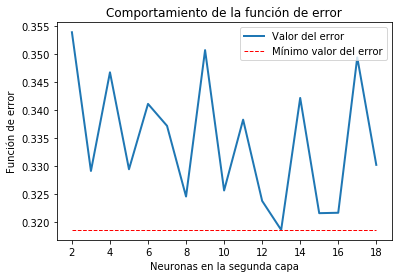

El modelo con mejor desempeño tiene 13 neuronas en la segunda capa oculta


In [29]:
plot_model_info(range(2,neurons),multi_models_log_loss_valid,'Neuronas en la segunda capa')
print("El modelo con mejor desempeño tiene %d neuronas en la segunda capa oculta" % best_model_multi_neurons)

In [32]:
trilayered_models_log_loss_valid = []

for units in range(2, best_model_multi_neurons):

    model = getMultiLayerMoldel(neurons = [neurons, best_model_multi_neurons, units])    
    history_data = model.fit(X_train, y_train,
                             validation_data=(X_validation,y_validation),
                             epochs=2000,
                             batch_size=32,
                             verbose=2,
                             callbacks=[earlyStop])

    trilayered_models_log_loss_valid.append(history_data.history['val_loss'][-1])

best_model_tri_position = trilayered_models_log_loss_valid.index(min(trilayered_models_log_loss_valid))
best_model_tri_neurons = best_model_tri_position + 2
print("El modelo con mejor desempeño tiene %d neuronas en la tercera capa oculta" % best_model_tri_neurons)

Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 - 1s - loss: 0.5443 - val_loss: 0.4162
Epoch 2/2000
6012/6012 - 0s - loss: 0.3947 - val_loss: 0.3867
Epoch 3/2000
6012/6012 - 0s - loss: 0.3702 - val_loss: 0.3737
Epoch 4/2000
6012/6012 - 0s - loss: 0.3560 - val_loss: 0.3597
Epoch 5/2000
6012/6012 - 0s - loss: 0.3453 - val_loss: 0.3545
Epoch 6/2000
6012/6012 - 0s - loss: 0.3350 - val_loss: 0.3497
Epoch 7/2000
6012/6012 - 0s - loss: 0.3284 - val_loss: 0.3461
Epoch 8/2000
6012/6012 - 0s - loss: 0.3207 - val_loss: 0.3446
Epoch 9/2000
6012/6012 - 0s - loss: 0.3149 - val_loss: 0.3432
Epoch 10/2000
6012/6012 - 0s - loss: 0.3086 - val_loss: 0.3355
Epoch 11/2000
6012/6012 - 0s - loss: 0.3044 - val_loss: 0.3404
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 - 1s - loss: 0.5837 - val_loss: 0.4432
Epoch 2/2000
6012/6012 - 0s - loss: 0.3951 - val_loss: 0.3984
Epoch 3/2000
6012/6012 - 0s - loss: 0.3674 - val_loss: 0.3768
Epoch 4/2000
6012/6012 - 0s - loss: 

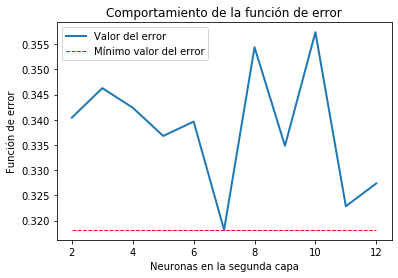

El modelo con mejor desempeño tiene 7 neuronas en la tercera capa oculta


In [35]:
plot_model_info(range(2,best_model_multi_neurons),trilayered_models_log_loss_valid,'Neuronas en la segunda capa')
print("El modelo con mejor desempeño tiene %d neuronas en la tercera capa oculta" % best_model_tri_neurons)

In [39]:
four_layered_models_log_loss_valid = []

for units in range(2, best_model_tri_neurons):

    model = getMultiLayerMoldel(neurons = [neurons, best_model_multi_neurons, best_model_tri_neurons, units])    
    history_data = model.fit(X_train, y_train,
                             validation_data=(X_validation,y_validation),
                             epochs=2000,
                             batch_size=32,
                             verbose=2,
                             callbacks=[earlyStop])

    four_layered_models_log_loss_valid.append(history_data.history['val_loss'][-1])

best_model_four_position = four_layered_models_log_loss_valid.index(min(four_layered_models_log_loss_valid))
best_model_four_neurons = best_model_four_position + 2
print("El modelo con mejor desempeño tiene %d neuronas en la cuarta capa oculta" % best_model_four_neurons)

Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 - 2s - loss: 0.5931 - val_loss: 0.5070
Epoch 2/2000
6012/6012 - 0s - loss: 0.4388 - val_loss: 0.3794
Epoch 3/2000
6012/6012 - 0s - loss: 0.3750 - val_loss: 0.3571
Epoch 4/2000
6012/6012 - 0s - loss: 0.3588 - val_loss: 0.3465
Epoch 5/2000
6012/6012 - 0s - loss: 0.3484 - val_loss: 0.3445
Epoch 6/2000
6012/6012 - 0s - loss: 0.3403 - val_loss: 0.3399
Epoch 7/2000
6012/6012 - 0s - loss: 0.3348 - val_loss: 0.3343
Epoch 8/2000
6012/6012 - 0s - loss: 0.3296 - val_loss: 0.3359
Train on 6012 samples, validate on 668 samples
Epoch 1/2000
6012/6012 - 2s - loss: 0.6374 - val_loss: 0.5470
Epoch 2/2000
6012/6012 - 0s - loss: 0.5340 - val_loss: 0.4907
Epoch 3/2000
6012/6012 - 0s - loss: 0.4927 - val_loss: 0.4612
Epoch 4/2000
6012/6012 - 0s - loss: 0.4651 - val_loss: 0.4401
Epoch 5/2000
6012/6012 - 0s - loss: 0.4414 - val_loss: 0.4234
Epoch 6/2000
6012/6012 - 0s - loss: 0.4226 - val_loss: 0.4076
Epoch 7/2000
6012/6012 - 0s - loss: 0.

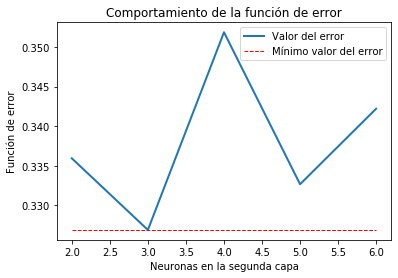

El modelo con mejor desempeño tiene 3 neuronas en la cuarta capa oculta


In [61]:
plot_model_info(range(2,best_model_tri_neurons),four_layered_models_log_loss_valid,'Neuronas en la segunda capa')
print("El modelo con mejor desempeño tiene %d neuronas en la cuarta capa oculta" % best_model_four_neurons)

#### Una vez obtenidas las neuronas en cada capa que poseen el mejor el rendimiento, se evalua una red neuronal entrenada en la totalidad de datos para este fin y se prueba cada arquitectura (dos, tres y cuatro capaz) en los datos separados para prueba.

In [75]:
model_four_layers = getMultiLayerMoldel(neurons = [neurons, 
                                       best_model_multi_neurons, 
                                       best_model_tri_neurons, 
                                       best_model_four_neurons])
model_four_layers.fit(X, y,
                      epochs=70,
                      batch_size=32,
                      verbose=1)

Train on 6680 samples
Epoch 1/70
6680/6680 [==============================] - 2s 269us/sample - loss: 0.5099
Epoch 2/70
6680/6680 [==============================] - 0s 68us/sample - loss: 0.3866
Epoch 3/70
6680/6680 [==============================] - 0s 68us/sample - loss: 0.3619
Epoch 4/70
6680/6680 [==============================] - 0s 73us/sample - loss: 0.3490
Epoch 5/70
6680/6680 [==============================] - 0s 65us/sample - loss: 0.3388
Epoch 6/70
6680/6680 [==============================] - 0s 65us/sample - loss: 0.3300
Epoch 7/70
6680/6680 [==============================] - 0s 65us/sample - loss: 0.3227
Epoch 8/70
6680/6680 [==============================] - 0s 68us/sample - loss: 0.3170
Epoch 9/70
6680/6680 [==============================] - 0s 73us/sample - loss: 0.3129
Epoch 10/70
6680/6680 [==============================] - 0s 63us/sample - loss: 0.3079
Epoch 11/70
6680/6680 [==============================] - 0s 63us/sample - loss: 0.3035
Epoch 12/70
6680/6680 [======

In [76]:
model_three_layers = getMultiLayerMoldel(neurons = [neurons, 
                                       best_model_multi_neurons, 
                                       best_model_tri_neurons])
model_three_layers.fit(X, y,
                      epochs=60,
                      batch_size=32,
                      verbose=1)

Train on 6680 samples
Epoch 1/60
6680/6680 [==============================] - 2s 236us/sample - loss: 0.6016
Epoch 2/60
6680/6680 [==============================] - 0s 65us/sample - loss: 0.3932
Epoch 3/60
6680/6680 [==============================] - 0s 58us/sample - loss: 0.3644
Epoch 4/60
6680/6680 [==============================] - 0s 61us/sample - loss: 0.3489
Epoch 5/60
6680/6680 [==============================] - 0s 63us/sample - loss: 0.3377
Epoch 6/60
6680/6680 [==============================] - 0s 65us/sample - loss: 0.3304
Epoch 7/60
6680/6680 [==============================] - 0s 68us/sample - loss: 0.3243
Epoch 8/60
6680/6680 [==============================] - 0s 65us/sample - loss: 0.3173
Epoch 9/60
6680/6680 [==============================] - 0s 68us/sample - loss: 0.3131
Epoch 10/60
6680/6680 [==============================] - 0s 58us/sample - loss: 0.3086
Epoch 11/60
6680/6680 [==============================] - 0s 65us/sample - loss: 0.3043
Epoch 12/60
6680/6680 [======

In [77]:
model_two_layers = getMultiLayerMoldel(neurons = [neurons, 
                                       best_model_multi_neurons])
model_two_layers.fit(X, y,
          epochs=120,
          batch_size=32,
          verbose=1)

Train on 6680 samples
Epoch 1/120
6680/6680 [==============================] - 1s 196us/sample - loss: 0.5586
Epoch 2/120
6680/6680 [==============================] - 0s 56us/sample - loss: 0.3973
Epoch 3/120
6680/6680 [==============================] - 0s 61us/sample - loss: 0.3713
Epoch 4/120
6680/6680 [==============================] - 0s 54us/sample - loss: 0.3573
Epoch 5/120
6680/6680 [==============================] - 0s 56us/sample - loss: 0.3464
Epoch 6/120
6680/6680 [==============================] - 0s 58us/sample - loss: 0.3374
Epoch 7/120
6680/6680 [==============================] - 0s 63us/sample - loss: 0.3303
Epoch 8/120
6680/6680 [==============================] - 0s 68us/sample - loss: 0.3228
Epoch 9/120
6680/6680 [==============================] - 0s 56us/sample - loss: 0.3168
Epoch 10/120
6680/6680 [==============================] - 0s 58us/sample - loss: 0.3118
Epoch 11/120
6680/6680 [==============================] - 0s 56us/sample - loss: 0.3067
Epoch 12/120
6680/

Epoch 94/120
6680/6680 [==============================] - 0s 61us/sample - loss: 0.2144
Epoch 95/120
6680/6680 [==============================] - 0s 54us/sample - loss: 0.2134
Epoch 96/120
6680/6680 [==============================] - 0s 61us/sample - loss: 0.2130
Epoch 97/120
6680/6680 [==============================] - 0s 61us/sample - loss: 0.2138
Epoch 98/120
6680/6680 [==============================] - 0s 55us/sample - loss: 0.2112
Epoch 99/120
6680/6680 [==============================] - 0s 54us/sample - loss: 0.2119
Epoch 100/120
6680/6680 [==============================] - 0s 56us/sample - loss: 0.2115
Epoch 101/120
6680/6680 [==============================] - 0s 58us/sample - loss: 0.2111
Epoch 102/120
6680/6680 [==============================] - 0s 54us/sample - loss: 0.2099
Epoch 103/120
6680/6680 [==============================] - 0s 58us/sample - loss: 0.2086
Epoch 104/120
6680/6680 [==============================] - 0s 58us/sample - loss: 0.2094
Epoch 105/120
6680/6680 [==

In [78]:
binAccuracy = binary_accuracy(y_test, squeeze(model_four_layers.predict(X_test)))
print('La precisión alcanzada por el modelo con cuatro capas escondidas en los datos de prueba es de %.2f%%' % (binAccuracy*100))

binAccuracy = binary_accuracy(y_test, squeeze(model_three_layers.predict(X_test)))
print('La precisión alcanzada por el modelo con tres capas escondidas en los datos de prueba es de %.2f%%' % (binAccuracy*100))

binAccuracy = binary_accuracy(y_test, squeeze(model_two_layers.predict(X_test)))
print('La precisión alcanzada por el modelo con dos capas escondidas en los datos de prueba es de %.2f%%' % (binAccuracy*100))

precision = 0.034
confianza = (1 - (2*math.exp(-2*(precision**2)*total_test_data))) *100

print('Esta estimación posee un %.1f%% de precisión con una confianza del %.2f%%' % (precision*100, confianza))


La precisión alcanzada por el modelo con cuatro capas escondidas en los datos de prueba es de 84.31%
La precisión alcanzada por el modelo con tres capas escondidas en los datos de prueba es de 84.55%
La precisión alcanzada por el modelo con dos capas escondidas en los datos de prueba es de 85.03%
Esta estimación posee un 3.4% de precisión con una confianza del 95.79%


### De los resultados obtenidos, se evidencia que las arquitecturas con más de dos capas ocultas tienen un peor rendimiento en el conjunto de prueba comparado con el modelo con solo una capa. Por otro lado, al analizar la red con dos capas ocultas, es posible observar que este apenas mejora el desempeño del modelo. Se imprimen la cantidad total de parámetros de este último modelo:

In [79]:
model_two_layers.summary()

Model: "sequential_280"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_741 (Dense)            (None, 19)                589       
_________________________________________________________________
dense_742 (Dense)            (None, 13)                260       
_________________________________________________________________
dense_743 (Dense)            (None, 1)                 14        
Total params: 863
Trainable params: 863
Non-trainable params: 0
_________________________________________________________________


### De la información mostrada, se evidencia que la cantidad de parámetros a entrenar es muy alta si se compara con el total de datos. Por lo que es posible concluir que, si se desea mejorar el desempeño de la red neural con dos o más capas, es necesario aumentar significativamente la cantidad de datos. Es importante aclarar que las épocas de entrenamiento para cada red se escogieron variando dicho parámetro con el fin de evitar sobreajuste en los datos de entrenamiento.

## Conclusiones:
- Fue posible construir un modelo de perceptrón multicapa para clasificación de canciones. Sin embargo, no fue posible crear una red muy profunda debido a la poca cantidad de datos disponibles.
- Se evidencia la importancia del conjunto de validación en el diseño de modelos complejos ya que éste permite escoger los hiperparámetros adecuadamente.
- Se observó la dificultad que existe a la hora de crear modelos de aprendizaje automático, debido a que necesario de entrenar gran cantidad de modelos antes de elegir una arquitectura definitiva.
- Los tiempo de ejecución del este Notebook puede acercarse a la hora, debido a que necesario entrenar numerosos modelos durante una gran cantidad de épocas